In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from typing import Dict

import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csr_matrix

import celeri

# Read in data files and do basic processing

In [3]:
# Japan example
# command_file_name = "../data/command/japan_command.json"

# Western North America example
command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2023-12-29 16:24:23.922 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json


2023-12-29 16:24:23.924 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2023-12-29-16-24-23
2023-12-29 16:24:23.925 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2023-12-29-16-24-23/2023-12-29-16-24-23.log
2023-12-29 16:24:23.926 | INFO     | celeri.celeri:read_data:129 - Reading data files
2023-12-29 16:24:23.936 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2023-12-29 16:24:23.940 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2023-12-29 16:24:23.943 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2023-12-29 16:24:23.998 | SUCCESS  | celeri.celeri:read_data:266 - Read: ../data/mesh/cascadia.msh
2023-12-29 16:24:24.001 | SUCCESS  | celeri.celeri:read_data:302 - Read: ../data/station/western_north_america_station.csv
2023-12-29 16:24:24.002 | INFO     | celeri.celeri:read_data:317 - No mogi_file_name
2023-12-29 16:24:24.003 | INFO     | celeri.celeri:read_data:339 - No sar_file_name


# Get elastic operators and TDE smoothing operators

In [5]:
# Calculate Okada partials for all segments
celeri.get_elastic_operators_okada(operators, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2023-12-29 16:24:24.722 | INFO     | celeri.celeri:get_elastic_operators_okada:1598 - Using precomputed elastic operators


# Calculate non-elastic operators

In [8]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
operators.rotation_to_slip_rate_to_okada_to_velocities = (
    operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2023-12-29 16:25:03.528 | INFO     | celeri.celeri:get_slip_rate_constraints:1164 - Found 1 slip rate constraints
2023-12-29 16:25:03.532 | INFO     | celeri.celeri:get_slip_rate_constraints:1167 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Plot input data

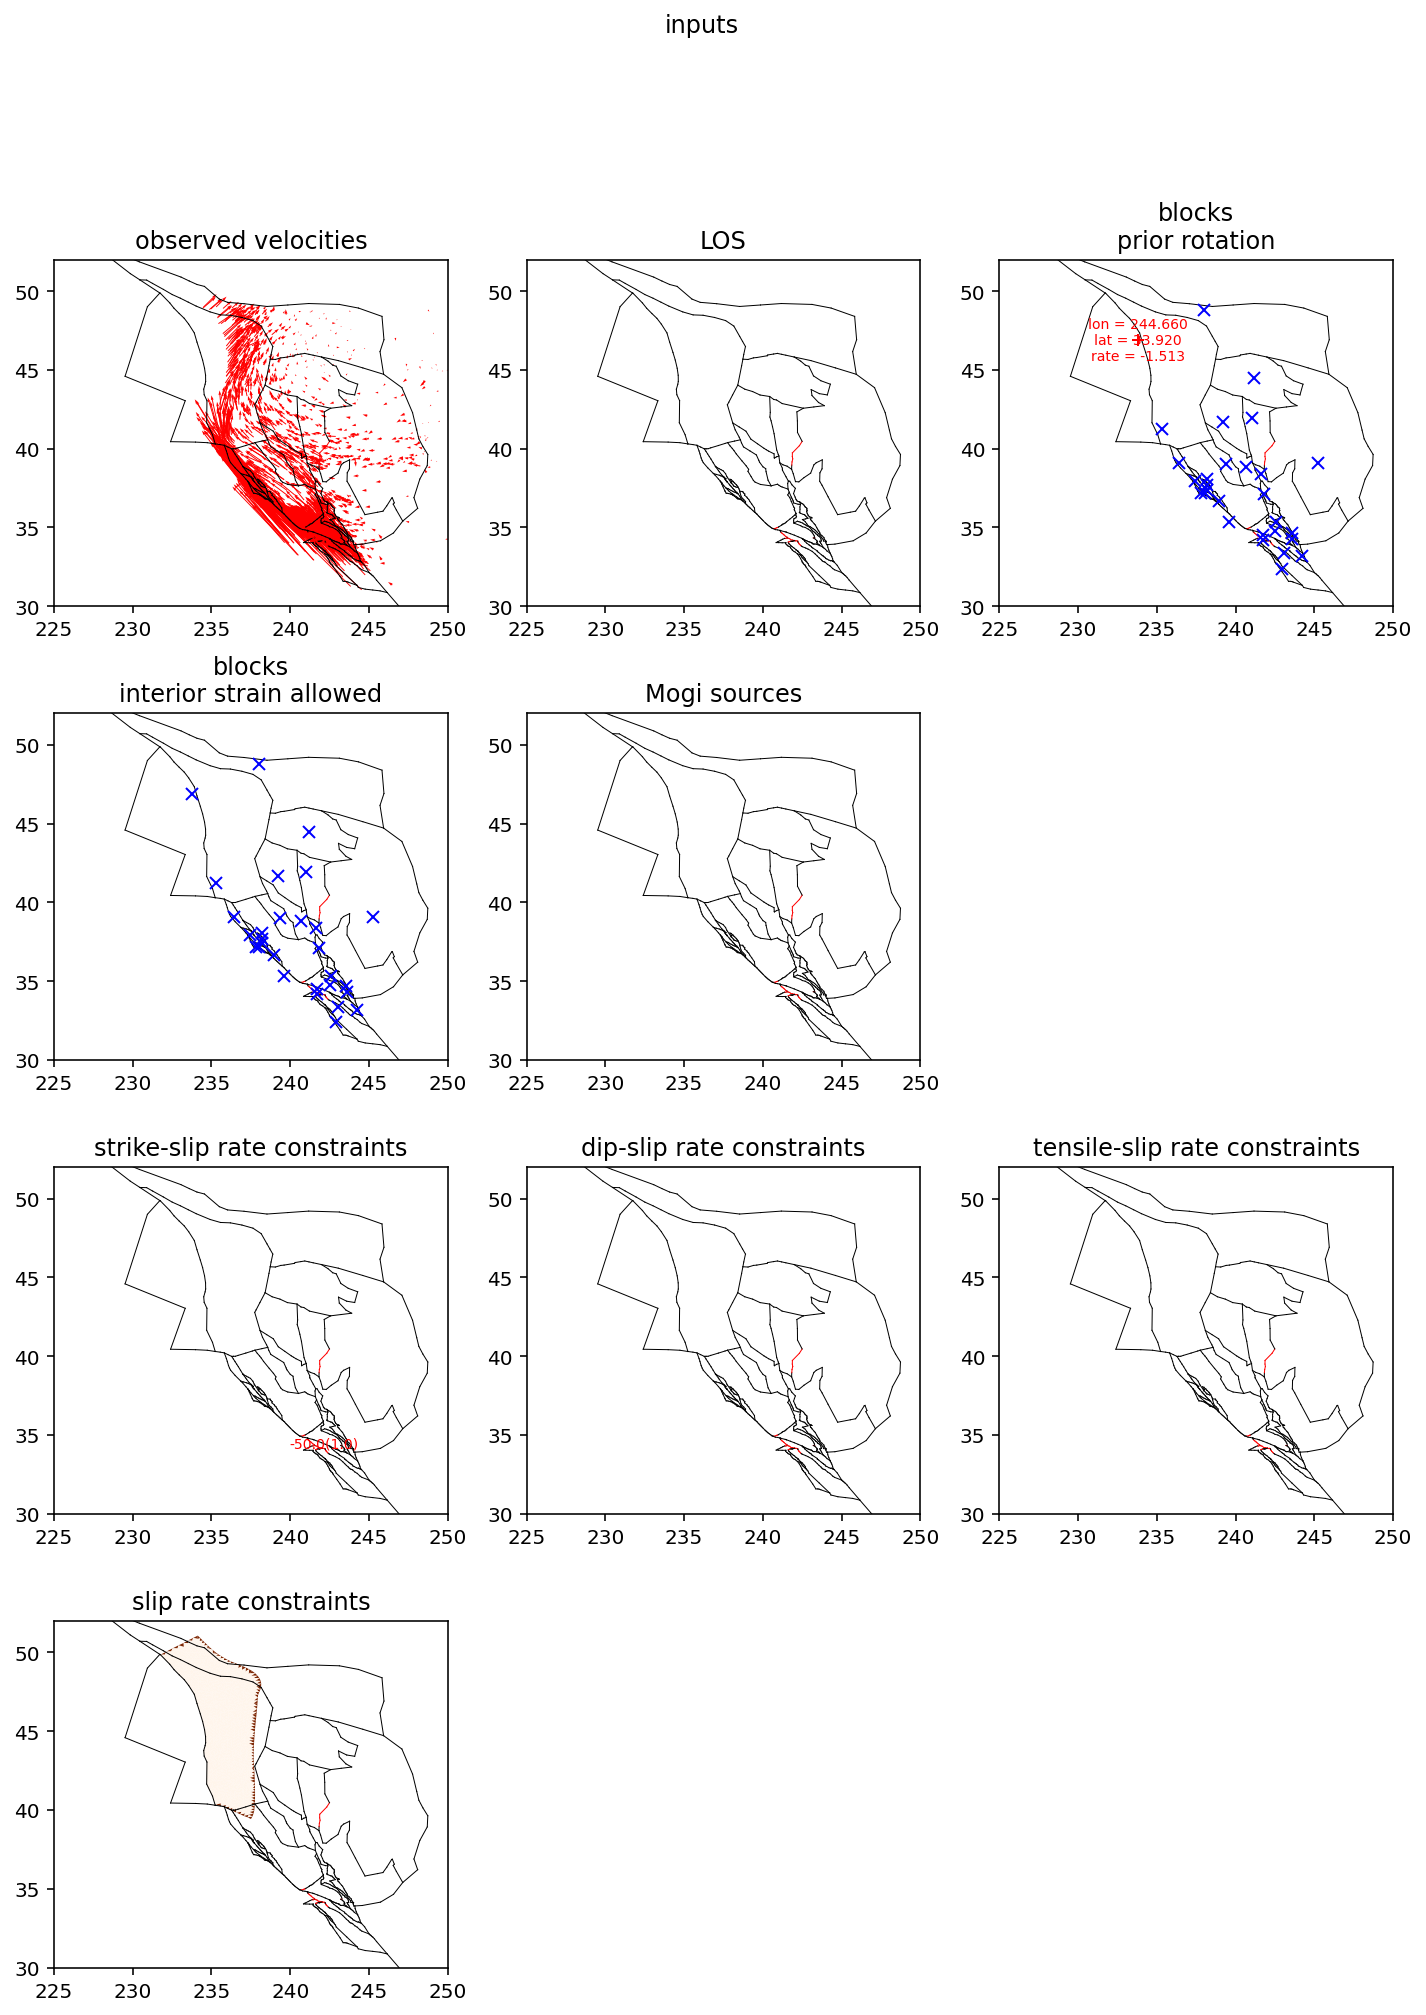

2023-12-29 16:25:10.723 | SUCCESS  | celeri.celeri:plot_input_summary:4085 - Wrote figures../runs/2023-12-29-16-24-23/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [9]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Calculate col_norms and H for each mesh here.

In [10]:
index = celeri.get_index(assembly, station, block, meshes)

# Data and data weighting vector
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
data_vector = celeri.get_data_vector(assembly, index)

# Apply data weighting
data_vector = data_vector * np.sqrt(weighting_vector)

# Cast all block submatrices to sparse
sparse_block_motion_okada_faults = csr_matrix(
    operators.rotation_to_velocities[index.station_row_keep_index, :]
    - operators.rotation_to_slip_rate_to_okada_to_velocities[
        index.station_row_keep_index, :
    ]
)
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

# Calculate column normalization vector for blocks
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector_block_only = weighting_vector[0 : operator_block_only.shape[0]][
    :, None
]
col_norms = np.linalg.norm(
    operator_block_only * np.sqrt(weighting_vector_block_only), axis=0
)

# Hmatrix decompositon for each TDE mesh
H, col_norms = celeri.get_h_matrices_for_tde_meshes(
    command, meshes, station, operators, index, col_norms
)

2023-12-29 16:25:14.248 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3348 - Using precomputed elastic operators
2023-12-29 16:25:14.324 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3375 - Saving elastic to velocity matrices to :../data/operators/western_north_america_elastic_operators.hdf5
2023-12-29 16:25:16.162 | INFO     | celeri.celeri:get_h_matrices_for_tde_meshes:3719 - mesh 0 (../data/mesh/cascadia.msh) H-matrix compression ratio: 0.0832


In [11]:
# Package parameters that matvec and rmatvec need for the iterative solve
h_matrix_solve_parameters = (
    index,
    meshes,
    H,
    operators,
    weighting_vector,
    col_norms,
    sparse_block_motion_okada_faults,
    sparse_block_motion_constraints,
    sparse_block_slip_rate_constraints,
)

# Instantiate the scipy the linear operator for the iterative solver to use
operator_hmatrix = scipy.sparse.linalg.LinearOperator(
    (index.n_operator_rows, index.n_operator_cols),
    matvec=celeri.matvec_wrapper(h_matrix_solve_parameters),
    rmatvec=celeri.rmatvec_wrapper(h_matrix_solve_parameters),
)

# Solve the linear system
sparse_hmatrix_solution = scipy.sparse.linalg.lsmr(
    operator_hmatrix, data_vector, atol=command.atol, btol=command.btol
)

# Correct the solution for the col_norms preconditioning.
sparse_hmatrix_state_vector = sparse_hmatrix_solution[0] / col_norms

2023-12-29 16:27:04.932 | WARNING  | celeri.celeri:post_process_estimation_hmatrix:3627 - Slip rate uncertainty estimates set to 1 because LSMR doesn't provide variance estimates


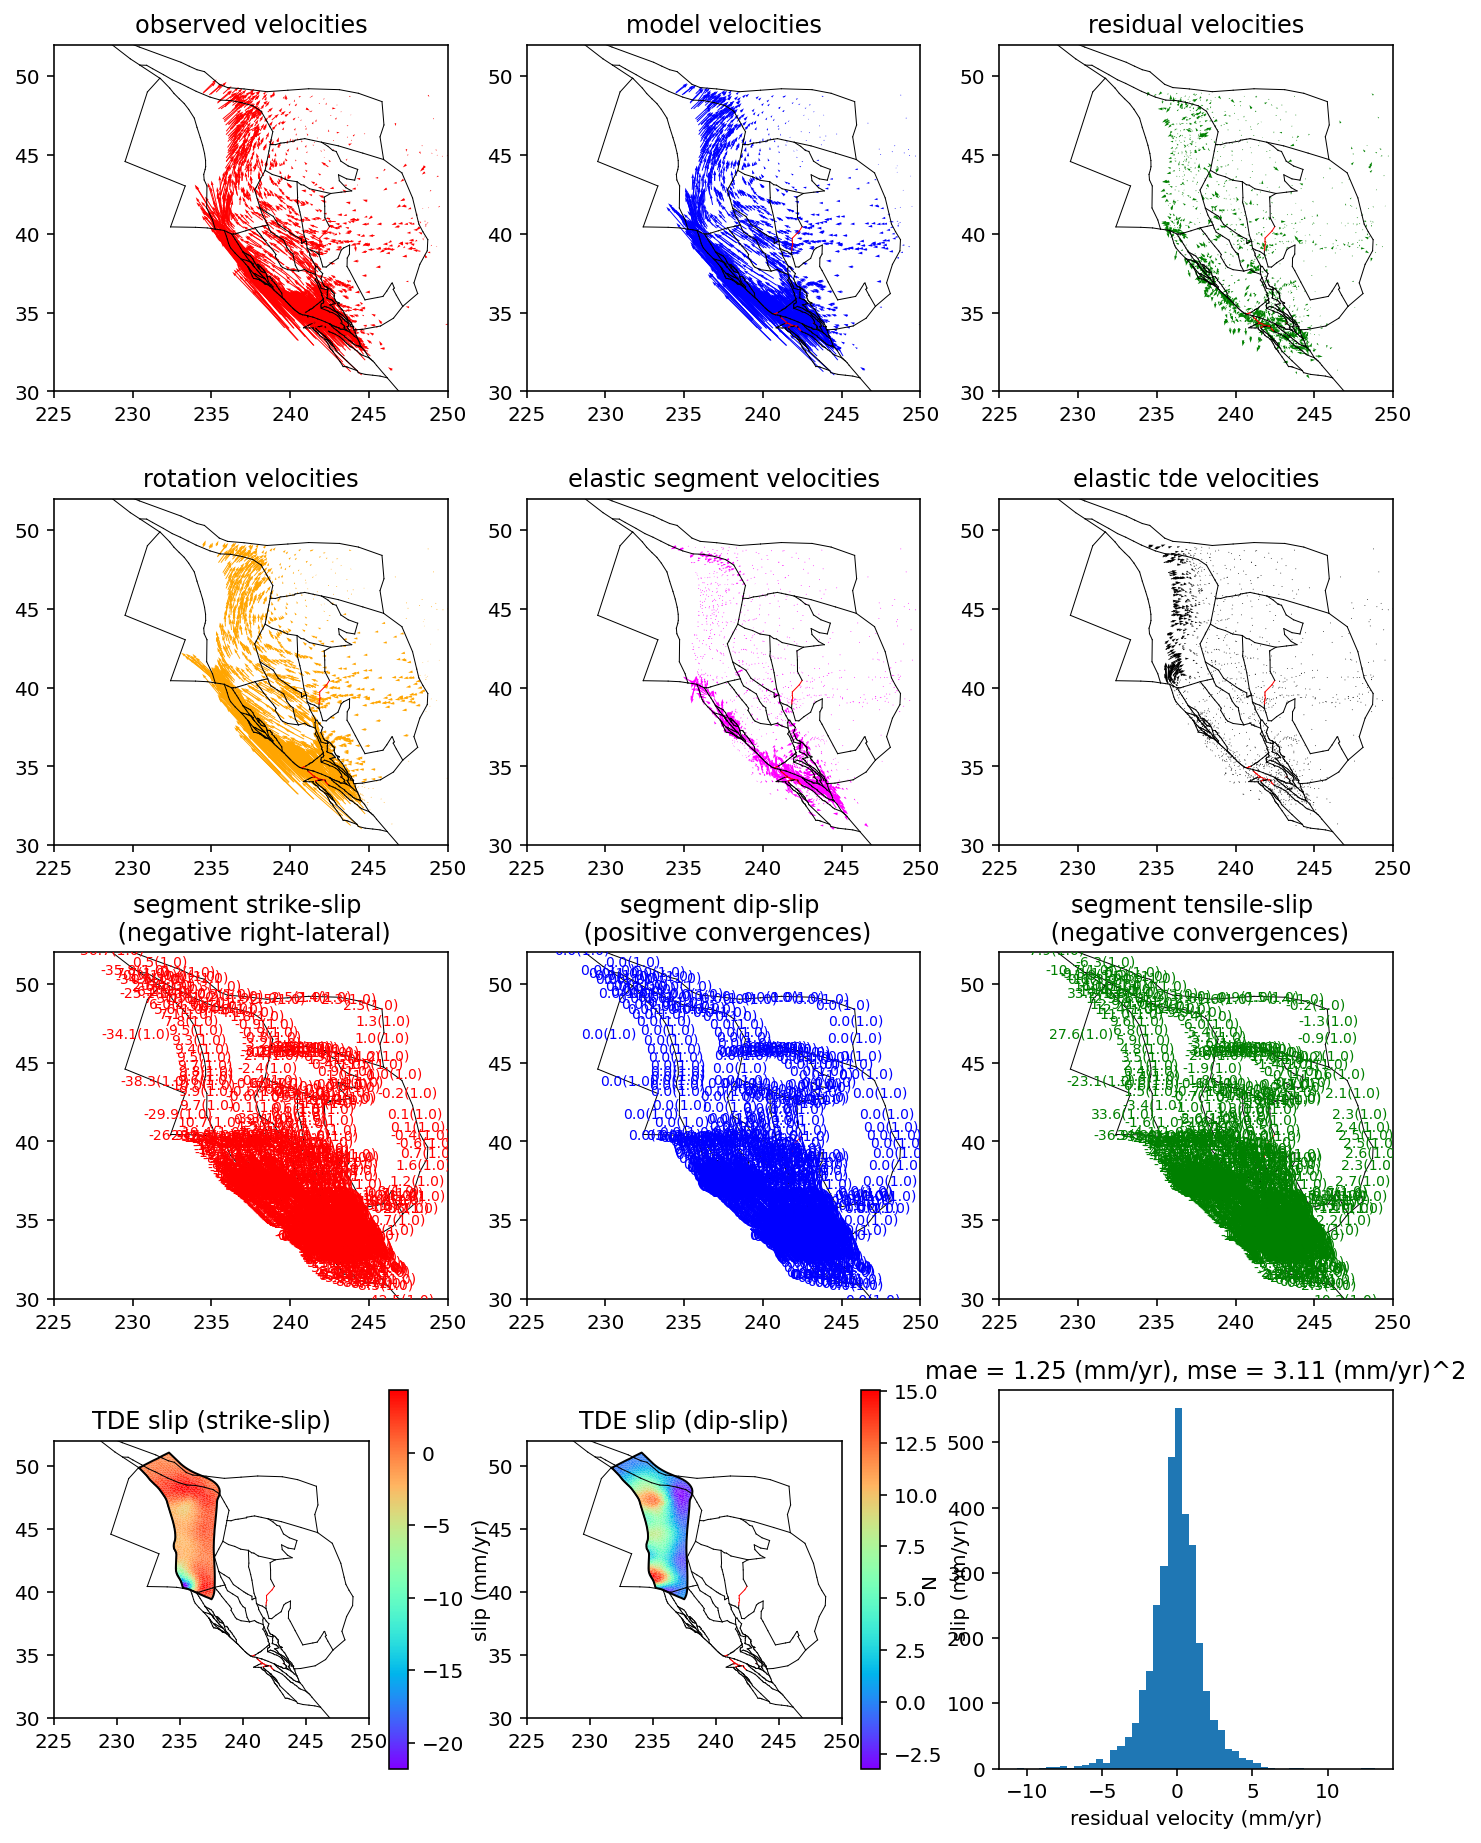

2023-12-29 16:27:11.832 | SUCCESS  | celeri.celeri:plot_estimation_summary:4585 - Wrote figures../runs/2023-12-29-16-24-23/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [13]:
estimation = addict.Dict()
estimation.data_vector = data_vector
estimation.weighting_vector = weighting_vector
estimation.operator = operator_hmatrix
estimation.state_vector = sparse_hmatrix_state_vector
# celeri.post_process_estimation_hmatrix(
#     estimation,
#     operators,
#     meshes,
#     H,
#     station,
#     index,
#     col_norms,
#     h_matrix_solve_parameters,
# )
celeri.post_process_estimation_hmatrix(
    command,
    block,
    estimation,
    operators,
    meshes,
    H,
    station,
    index,
    col_norms,
    h_matrix_solve_parameters,
)

celeri.write_output(command, estimation, station, segment, block, meshes)
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# lsq_linear experiment
- Doesn't work on size checks.  May need to simply eliminate all size checks?

In [14]:
lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# Strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# Dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

In [25]:
from scipy.optimize import lsq_linear

# Non-linear solver (bounded [-inf, inf])
res = lsq_linear(
    H,
    estimation.data_vector,
    bounds=(lower_bound, upper_bound),
    verbose=1,
)

import copy

estimation_bounded = copy.deepcopy(estimation)
estimation_bounded.state_vector = res.x
celeri.post_process_estimation(estimation_bounded, operators, station, index)

ValueError: Inconsistent shapes between `A` and `b`.

In [24]:
estimation.operator * estimation.weighting_vector

ValueError: dimension mismatch

In [17]:
estimation.weighting_vector[:, None].shape

(7230, 1)